# Analysis 2.1
- Outcome: ugica over 3 years
- Model: Individual log reg models for each subtype 
- Feature selection: Significant variables based on univariate analysis
- Predicts 3 year risk for combined UGI cancer outcome based on additive risk from subtype-specific models 
- Risk score threshold determined on 1) optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [78]:
model = 'logreg'
analysis_num = '2.1'
outcome_interval = "_3yr"

outcome_event = f'ugica{outcome_interval}'
subtypes = [f'escc{outcome_interval}', f'eac{outcome_interval}', f'ncgc{outcome_interval}', f'cgc{outcome_interval}']


In [74]:
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_all_subtypes.csv'
json_filename = './../notebook/thresholds.json'

ro.globalenv['subtypes'] = list(subtypes)
ro.globalenv['subtypes'] = list(subtypes)
ro.globalenv['outcome_event'] = outcome_event

In [44]:
# Load the JSON file
with open(json_filename, "r") as f:
    model_variables = json.load(f)

## Import each subtype-specific model and the variables for each model

In [45]:
selected_vars = set()
for subtype in subtypes:
    model_vars = set(model_variables[model][subtype]['variables'])
    selected_vars.update(model_vars)
    print(subtype, model_vars)

ro.globalenv['selected_vars'] = list(selected_vars)
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean'] # Needed to factorize categorical vars later

escc_3yr {'famhx_cancer', 'PPI', 'famhx_colonca', 'age'}
eac_3yr {'PPI', 'age', 'famhx_cancer', 'tobacco_binary', 'gerd', 'NSAID', 'hnca', 'pud', 'race_clean', 'sex_missing'}
ncgc_3yr {'PPI', 'age', 'gerd', 'cad', 'ethnicity', 'hnca', 'pud', 'race_clean', 'sex_missing'}
cgc_3yr {'PPI', 'famhx_cancer', 'tobacco_binary', 'cad', 'ethnicity', 'hnca', 'age', 'famhx_gastricca', 'race_clean', 'sex_missing'}


In [47]:
for subtype in subtypes: 
    model_name = f'logreg_{subtype}.rds'
    ro.globalenv[f'logreg_{subtype}'] = model_name

## Factorize categorical vars and set reference levels

In [37]:
%%R
# Remove categorical variables that we do not want to include in analysis
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')

## Partition data

In [24]:
%%R 
unlist(selected_vars)

 [1] "PPI"             "tobacco_binary"  "cad"             "NSAID"          
 [5] "famhx_cancer"    "pud"             "gerd"            "ethnicity"      
 [9] "famhx_colonca"   "hnca"            "age"             "famhx_gastricca"
[13] "race_clean"      "sex_missing"    


In [42]:
%%R 
selected_vars <- unlist(selected_vars) # Convert from list to a character vector 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set


[1] "Dataset Controls 34092" "Dataset Cases 91"      
[1] "Training Controls 27274" "Training Cases 73"      
[1] "Validation Controls 6818" "Validation Cases 18"     



## Results

### Estimate risk for each subtype and add to get combined ugica risk

In [49]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
risk_col_subtypes <- c() 

# Get the predicted risk 
for (subtype in subtypes) {
    # Load x model for that subtype 
    model_name <- paste0('logreg_', subtype, '.RDS')
    model <- readRDS(model_name)

    # Predict risk of that subtype
    pred_risk <- calculate_risk_from_logreg(model, validation_set)

    # Save risk column
    risk_col_name <- paste0('pred_risk_', subtype)
    risk_col_subtypes <- c(risk_col_subtypes, risk_col_name)
    r_df_validation_risk[[risk_col_name]] <- pred_risk
}

r_df_validation_risk$pred_risk_cum <- rowSums(r_df_validation_risk[, risk_col_subtypes])
names(r_df_validation_risk)

 [1] "time"               "event_ugica"        "event_escc"        
 [4] "event_eac"          "event_cgc"          "event_ncgc"        
 [7] "race"               "sex"                "age_bucket"        
[10] "visit_year_bucket"  "ugica_5yr"          "escc_5yr"          
[13] "eac_5yr"            "cgc_5yr"            "ncgc_5yr"          
[16] "ugica_1yr"          "escc_1yr"           "eac_1yr"           
[19] "cgc_1yr"            "ncgc_1yr"           "ugica_3yr"         
[22] "escc_3yr"           "eac_3yr"            "cgc_3yr"           
[25] "ncgc_3yr"           "ugica_10yr"         "escc_10yr"         
[28] "eac_10yr"           "cgc_10yr"           "ncgc_10yr"         
[31] "pred_risk_escc_3yr" "pred_risk_eac_3yr"  "pred_risk_ncgc_3yr"
[34] "pred_risk_cgc_3yr"  "pred_risk_cum"     


### Sensitivity and Metrics at 70% specificity

In [65]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])

pred_risk <- r_df_validation_risk$pred_risk_cum
actual_event <- r_df_validation_risk[[outcome_event]]

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(pred_risk, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, actual_event, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.757 
Sensitivity: 0.6666667 
Specificity: 0.700352 
PPV: 0.005839416 
NPV: 0.998745 
NNS: 218.1287 
     predicted_class
event    0    1
    0 4775 2043
    1    6   12


### Sensitivity and Metrics at threshold that maximizes Youdens

In [66]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = actual_event, predictor = pred_risk)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(pred_risk, actual_event, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.757 
Sensitivity: 0.6666667 
Specificity: 0.7717806 
PPV: 0.007653061 
NPV: 0.998861 
NNS: 153.5129 
     predicted_class
event    0    1
    0 5262 1556
    1    6   12


### AUROC curves and PR curve

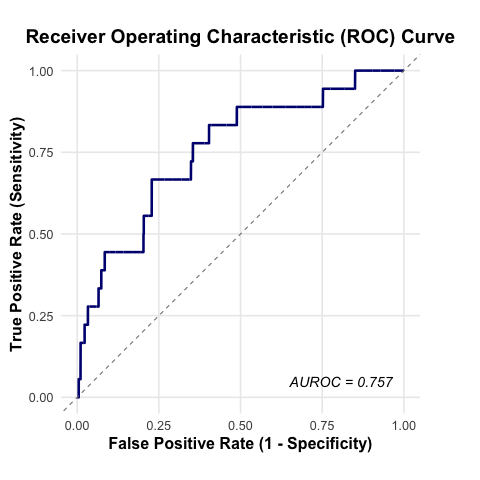

In [67]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(actual_event, pred_risk)
p2 <- plot_pr_gg(actual_event, pred_risk)

p1

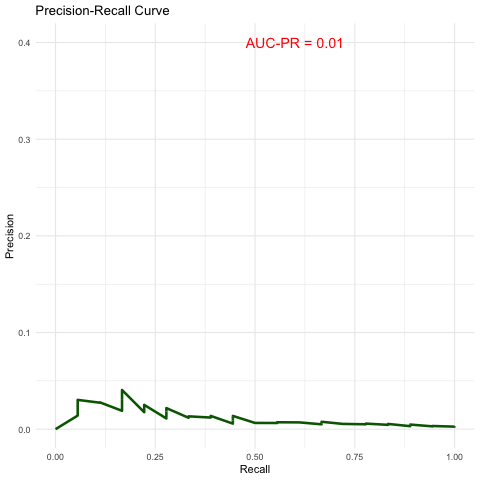

In [68]:
%%R
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [69]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk_cum'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [70]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,ugica_10yr,escc_10yr,eac_10yr,cgc_10yr,ncgc_10yr,pred_risk_escc_3yr,pred_risk_eac_3yr,pred_risk_ncgc_3yr,pred_risk_cgc_3yr,pred_risk_cum,actual_percentile,risk_group,risk_p0.5,risk_p0.5851375073142189,risk_p0.6,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden,risk_p0.7706260971328263
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000201,0.000246,0.000790,0.000037,0.001273,0.286571,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000206,0.000107,0.000792,0.000018,0.001122,0.230544,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000215,0.019169,0.002841,0.000350,0.022575,0.996197,0.99,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000200,0.000053,0.000894,0.000086,0.001234,0.276624,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000436,0.001490,0.001661,0.000571,0.004158,0.856788,0.85,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1


In [77]:
outcome_event

'ugica__3yr'

In [80]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [81]:
df_results.tail(5)

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ugica_3yr,70-79,1956,4,464,2 (0.4%),0.4,2,462,2,1494,0.763265,0.236735,50.000000,76.380368,0.431034,99.866310,336.310078,0.263804
71,high_risk_youden,youden,ugica_3yr,50-59,1267,4,274,4 (1.5%),1.5,4,270,0,997,0.787569,0.212431,100.000000,78.689818,1.459854,100.000000,68.500000,0.786898
72,high_risk_youden,youden,ugica_3yr,2011-2014,2867,1,705,1 (0.1%),0.1,1,704,0,2163,0.754533,0.245467,100.000000,75.444716,0.141844,100.000000,705.000000,0.754447
73,high_risk_youden,youden,ugica_3yr,2015-2018,2285,15,560,10 (1.8%),1.8,10,550,5,1735,0.758696,0.241304,66.666667,75.929978,1.785714,99.712644,66.739726,0.425966
74,high_risk_youden,youden,ugica_3yr,2019-2022,1666,2,303,1 (0.3%),0.3,1,302,1,1364,0.818345,0.181655,50.000000,81.872749,0.330033,99.926740,389.449153,0.318727


In [82]:
df_results.to_csv(risk_results_filename)

### Prevalance of cancer as a function of risk percentile by subtype

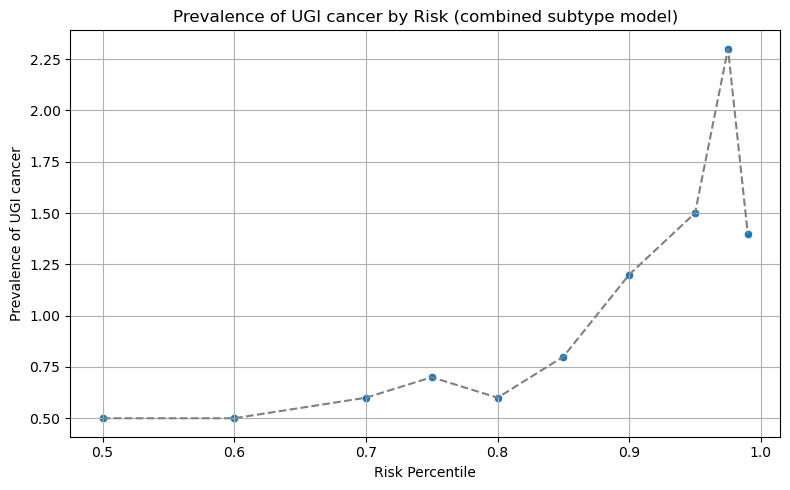

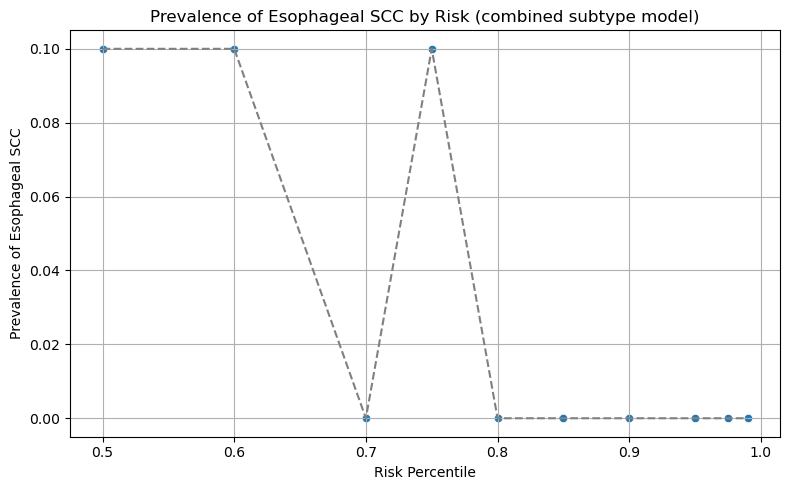

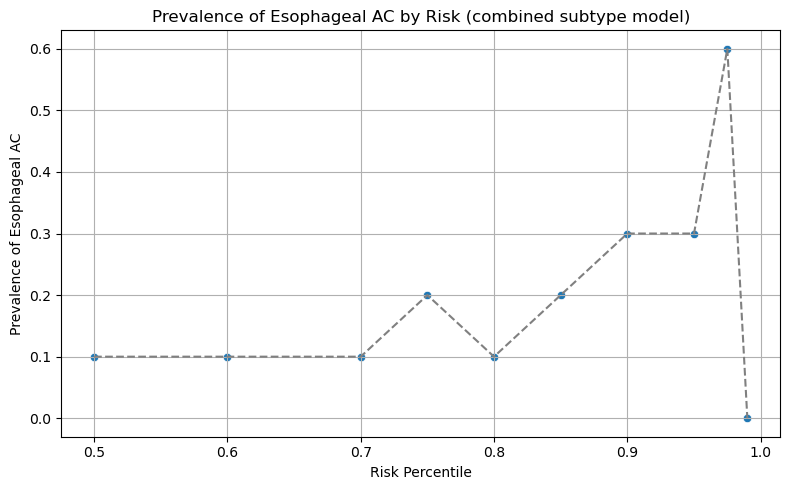

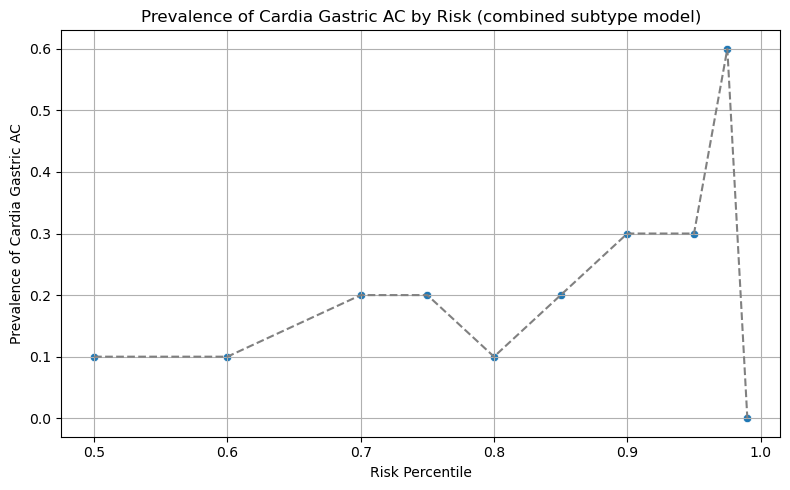

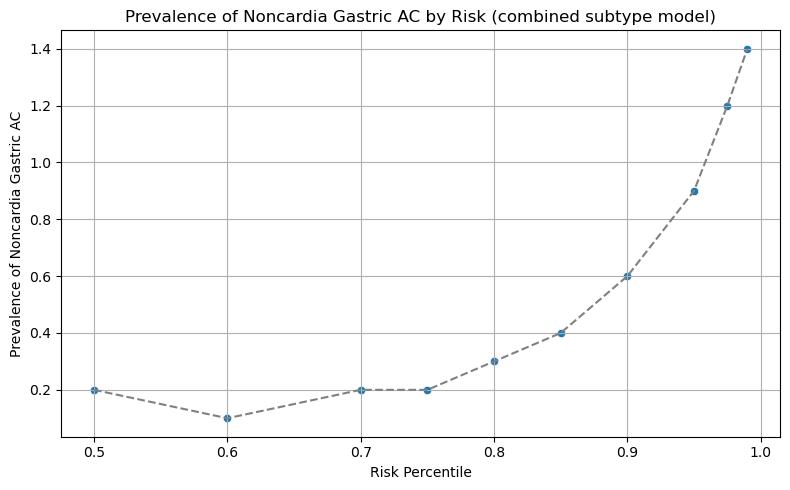

In [90]:
event_pretty_label = {
    f'ugica{outcome_interval}': "UGI cancer", 
    f'escc{outcome_interval}': "Esophageal SCC",
    f'eac{outcome_interval}': "Esophageal AC",
    f'cgc{outcome_interval}': "Cardia Gastric AC",
    f'ncgc{outcome_interval}': "Noncardia Gastric AC"
}

df_results_plot = df_results[~df_results['risk_percentile'].isin(['youden', optimal_threshold_percentile])]

for event in events:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Percentile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}')
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk (combined subtype model)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Kaplan Meier survival curves stratified by risk group

In [84]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,5250,1546
1.0,18,22


In [85]:
# Pass dataframe to R to analyze
ro.globalenv['r_df_validation_risk'] = df_validation_risk

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


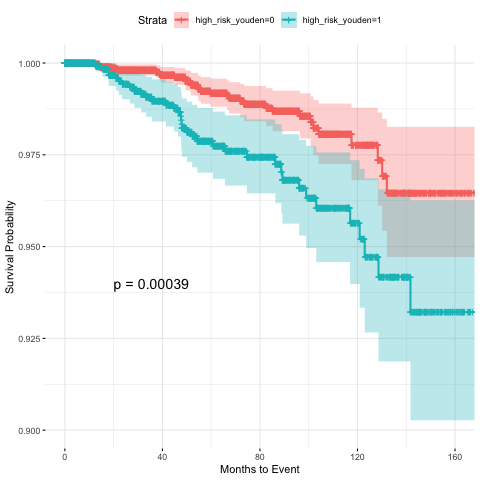

In [86]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot